In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from tensorflow.keras.models import load_model
import os
import time
import pandas as pd

In [2]:

# Model paths
model_paths = [
    'pest_detection_model2_v2.h5',
    'pest_detection_model3_v2.h5'
]

In [3]:
# Load models
models = [load_model(path) for path in model_paths]
model_names = ['DenseNet121', 'Xception']

In [4]:
# Dataset path
dataset_path = r"C:\Users\HP\OneDrive\Desktop\Minor Project 6 th sem\dataset\farm_insects"


In [5]:
# Image settings
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 1  # For accurate timing
EPOCHS = 30

In [6]:
# Generator for evaluation (no shuffle)
test_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

val_data_no_shuffle = test_datagen.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

y_true = val_data_no_shuffle.classes
n_samples = len(y_true)

Found 310 images belonging to 14 classes.


In [7]:
# Helper to evaluate model
def evaluate_model(model, data, model_name):
    start_time = time.time()
    preds = model.predict(data, verbose=0)
    end_time = time.time()

    y_pred = np.argmax(preds, axis=1)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    inference_time = ((end_time - start_time) / n_samples) * 1000  # ms per image

    return {
        "Model": model_name,
        "Accuracy": round(accuracy * 100, 2),
        "Precision": round(precision * 100, 2),
        "Recall": round(recall * 100, 2),
        "F1-Score": round(f1 * 100, 2),
        "Inference Time (ms)": round(inference_time, 2)
    }

In [8]:
# Evaluate individual models
results = [evaluate_model(model, val_data_no_shuffle, name) for model, name in zip(models, model_names)]


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [9]:
# Evaluate Ensemble
def get_ensemble_preds(models, data):
    all_preds = [model.predict(data, verbose=0) for model in models]
    avg_preds = np.mean(np.array(all_preds), axis=0)
    return avg_preds

start_ens_time = time.time()
ensemble_preds = get_ensemble_preds(models, val_data_no_shuffle)
end_ens_time = time.time()

y_pred_ensemble = np.argmax(ensemble_preds, axis=1)
accuracy = accuracy_score(y_true, y_pred_ensemble)
precision = precision_score(y_true, y_pred_ensemble, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred_ensemble, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred_ensemble, average='weighted', zero_division=0)
ensemble_inference_time = ((end_ens_time - start_ens_time) / n_samples) * 1000

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [10]:
# Add ensemble results
results.append({
    "Model": "Ensemble",
    "Accuracy": round(accuracy * 100, 2),
    "Precision": round(precision * 100, 2),
    "Recall": round(recall * 100, 2),
    "F1-Score": round(f1 * 100, 2),
    "Inference Time (ms)": round(ensemble_inference_time, 2)
})

In [11]:
# Show as table
df = pd.DataFrame(results)
print("\n📊 Model Performance Table:\n")
print(df.to_string(index=False))


📊 Model Performance Table:

      Model  Accuracy  Precision  Recall  F1-Score  Inference Time (ms)
DenseNet121     78.39      78.90   78.39     78.17               234.34
   Xception     74.84      75.37   74.84     74.84               201.68
   Ensemble     77.10      77.77   77.10     76.93               409.36


In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [13]:
# Get class labels
class_indices = val_data_no_shuffle.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

In [14]:
# Get true and predicted labels (already predicted earlier)
y_true = val_data_no_shuffle.classes
y_pred = np.argmax(ensemble_preds, axis=1)

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

In [16]:
# Per-class accuracy: Diagonal / Row sum
per_class_acc = cm.diagonal() / cm.sum(axis=1)

In [17]:
# Convert to dict with class names
class_wise_accuracy = {idx_to_class[i]: acc * 100 for i, acc in enumerate(per_class_acc)}


C:\Users\HP\AppData\Local\Temp\ipykernel_12672\665982252.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_wise_accuracy.keys()), y=list(class_wise_accuracy.values()), palette="viridis")


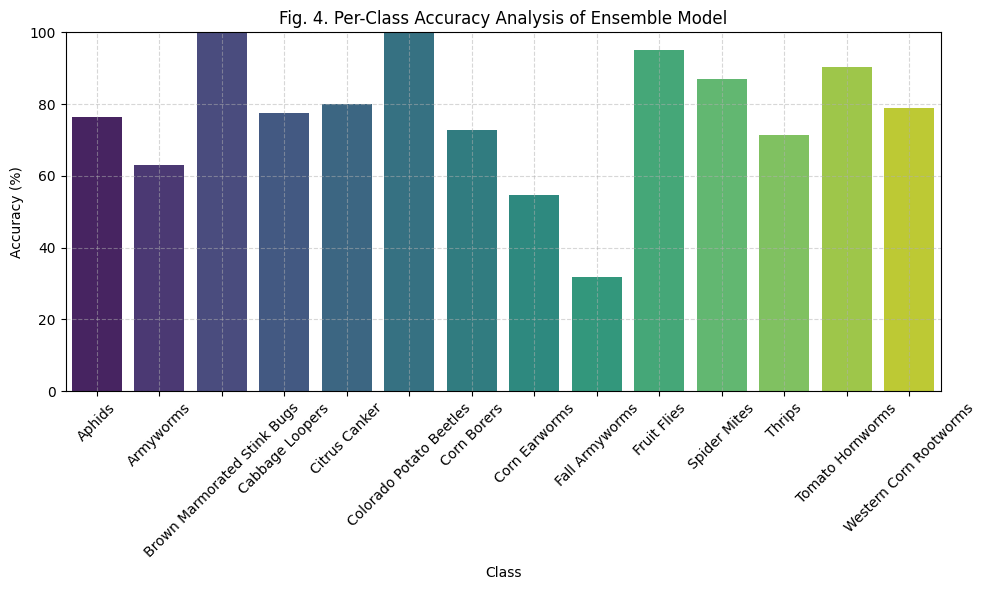

In [47]:
# 📊 Plotting the figure — Fig. 6
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_wise_accuracy.keys()), y=list(class_wise_accuracy.values()), palette="viridis")
plt.ylabel('Accuracy (%)')
plt.xlabel('Class')
plt.title('Fig. 4. Per-Class Accuracy Analysis of Ensemble Model')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [30]:
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

<Figure size 1000x800 with 0 Axes>

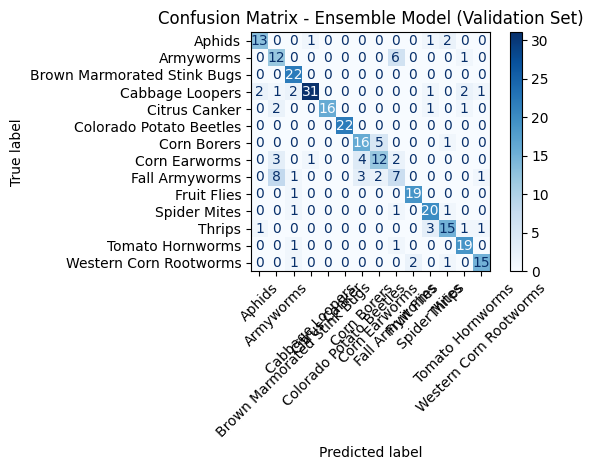

In [31]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, colorbar=True)
plt.title("Confusion Matrix - Ensemble Model (Validation Set)")
plt.tight_layout()
plt.show()

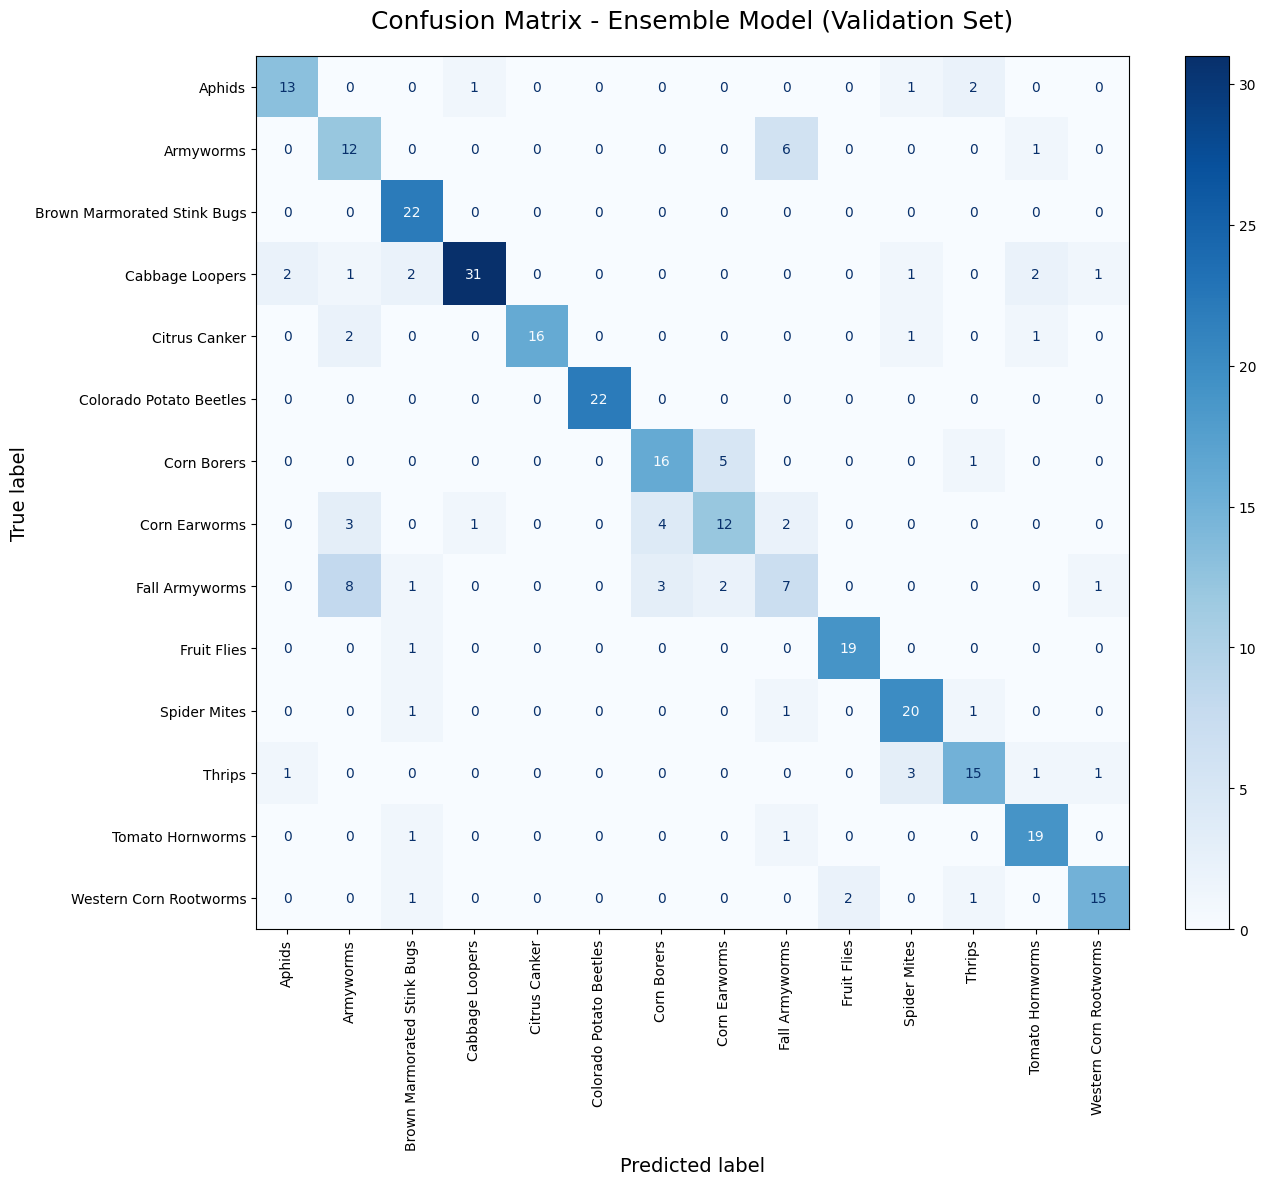

In [42]:
fig, ax = plt.subplots(figsize=(14, 12))  # Larger figure for better spacing
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=True)

# Title and axes labels
ax.set_title("Confusion Matrix - Ensemble Model (Validation Set)", fontsize=18, pad=20)
ax.set_xlabel("Predicted label", fontsize=14)
ax.set_ylabel("True label", fontsize=14)

# Tweak ticks and rotation for readability
plt.setp(ax.get_xticklabels(), rotation=90, ha='center', fontsize=10)
plt.setp(ax.get_yticklabels(), fontsize=10)

# Improve layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Reserve space for title
plt.grid(False)

plt.show()


In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Function to get predictions from models
def get_model_preds(models, data):
    all_preds = [model.predict(data, verbose=0) for model in models]
    return np.array(all_preds)

In [46]:
# Get predicted probabilities for both DenseNet and Xception models using the loaded models
preds = get_model_preds(models, val_data_no_shuffle)

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [48]:
# Get predicted confidence scores (probabilities)
# Ensemble model confidence (mean of model predictions)
ensemble_confidences = np.max(np.mean(preds, axis=0), axis=1)

# Get confidence scores for DenseNet and Xception separately
densenet_confidences = np.max(preds[0], axis=1)  # DenseNet model confidence scores
xception_confidences = np.max(preds[1], axis=1)  # Xception model confidence scores

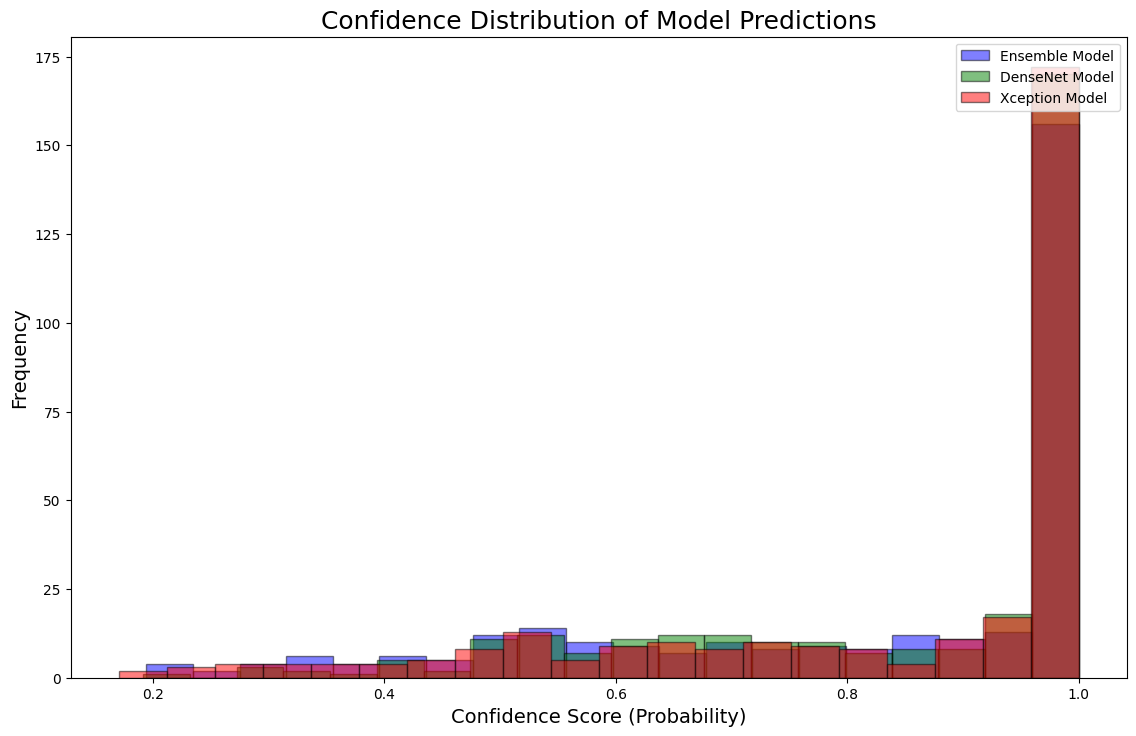

In [49]:
# Plotting confidence distributions
plt.figure(figsize=(12, 8))

# Plot Ensemble confidence distribution
plt.hist(ensemble_confidences, bins=20, alpha=0.5, label="Ensemble Model", color='b', edgecolor='black')

# Plot DenseNet confidence distribution
plt.hist(densenet_confidences, bins=20, alpha=0.5, label="DenseNet Model", color='g', edgecolor='black')

# Plot Xception confidence distribution
plt.hist(xception_confidences, bins=20, alpha=0.5, label="Xception Model", color='r', edgecolor='black')

# Add title and labels
plt.title("Confidence Distribution of Model Predictions", fontsize=18)
plt.xlabel("Confidence Score (Probability)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(loc="upper right")

# Show the plot
plt.tight_layout(pad=3.0)
plt.show()